## Librerias 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from lib.LCWavelet import *
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import optuna

## Arquitectura del modelo

In [2]:
class ShallueModel(nn.Module):
    def __init__(self, global_size=2001, local_size=201, num_classes=2):
        super(ShallueModel, self).__init__()
        self.global_size = global_size
        self.local_size = local_size
        self.num_classes = num_classes
        if num_classes == 1:
            print("Binary classification, sigmoid activation will be used.")
        elif num_classes > 1:
            print("Multi-class classification, softmax activation will be used.")
            
        
        self.conv_global = nn.Sequential(
            nn.Conv1d(2, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(64, 128, 5),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(128, 256, 5),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
        )
    
        
        self.conv_local = nn.Sequential(
            nn.Conv1d(2, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
        )

        
        # Calcular automáticamente el número de features resultantes de la concatenación
        with torch.no_grad():
            dummy_global = torch.zeros(1, 2, self.global_size)
            dummy_local = torch.zeros(1, 2, self.local_size)
            out_global  = self.conv_global(dummy_global)
            out_local   = self.conv_local(dummy_local)

            
            # Flatten cada salida y sumar sus dimensiones
            num_features = out_global.view(1, -1).size(1) + out_local.view(1, -1).size(1)
            
        print("Número de features concatenados:", num_features)
        
        self.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, inputs):
        global_feat = self.conv_global(inputs[0])
        local_feat = self.conv_local(inputs[1])

        
        global_feat = global_feat.view(global_feat.size(0), -1)
        local_feat = local_feat.view(local_feat.size(0), -1)

        # Concatenación de todas las ramas
        x = torch.cat((global_feat, local_feat), dim=1)
        x = self.fc(x)
        if self.num_classes > 1:
            return F.softmax(x, dim=1)
        else:
            return torch.sigmoid(x)
    

## Cargado de datos

In [3]:
def load_data(path, file_name):
    lc = LightCurveWaveletGlobalLocalCollection.from_pickle(path + file_name)
    try:
        getattr(lc, 'levels')
    except AttributeError:
        lc.levels = [1, 2, 3, 4]
    return lc
        
path='all_data/'
files = os.listdir(path)
kepler_files = [f for f in files if f.endswith('.pickle')]
light_curves = []

for file in tqdm(kepler_files, desc='Loading data'):
    light_curves.append(load_data(path, file))

Loading data: 100%|██████████| 9346/9346 [03:03<00:00, 50.92it/s]


### Separar entre los confirmados y candidatos

In [5]:
candidates = [lc for lc in light_curves if lc.headers['class'] == 'CANDIDATE']
print("Número de candidatos:", len(candidates))

confirmed = [lc for lc in light_curves if lc.headers['class'] == 'CONFIRMED' or lc.headers['class'] == 'FALSE POSITIVE']
print("Número de confirmados:", len(confirmed))

# classes = [lc.headers['class'] for lc in confirmed]
# classes = set(classes)
# classes = {v: k for k, v in enumerate(classes)}
classes = {'FALSE POSITIVE': 0, 'CONFIRMED': 1}
print("Clases:", classes)

Número de candidatos: 2046
Número de confirmados: 7300
Clases: {'FALSE POSITIVE': 0, 'CONFIRMED': 1}


In [6]:
global_odd = []
global_even = []
local_odd = []
local_even = []
labels = []

for lc in tqdm(confirmed, desc='Processing light curves'):
    global_odd.append(lc.pliegue_impar_global._light_curve.flux.value)
    global_even.append(lc.pliegue_par_global._light_curve.flux.value)
    local_odd.append(lc.pliegue_impar_local._light_curve.flux.value)
    local_even.append(lc.pliegue_par_local._light_curve.flux.value)
    # Convertir la clase a un número entero
    labels.append(classes[lc.headers['class']])
    
print("Número de datos:", len(global_odd))
print('Elementos de cada clase:', {k: labels.count(k) for k in set(labels)})


Processing light curves: 100%|██████████| 7300/7300 [00:00<00:00, 117324.09it/s]

Número de datos: 7300
Elementos de cada clase: {0: 4637, 1: 2663}


#### Ajustar los datos para que sean equiprobables (data augmentation)

In [18]:
# Ajustar el numero de elementos de cada clase
min_class_size = min([list(labels).count(i) for i in set(labels)])
max_class_size = max([list(labels).count(i) for i in set(labels)])
min_class = min([i for i in set(labels) if list(labels).count(i) == min_class_size])
max_class = max([i for i in set(labels) if list(labels).count(i) == max_class_size])
print("Tamaño máximo de clase:", max_class_size)
print("Tamaño mínimo de clase:", min_class_size)

# coger los datos de la clase con menos elementos y generar un dato nuevo dandole la vuelta a la señal hasta que tenga el mismo número de elementos que la clase con más elementos
for i in range(len(labels)):
    if labels[i] == min_class: # clase con menos elementos
        global_odd.append(global_odd[i][::-1])
        global_even.append(global_even[i][::-1])
        local_odd.append(local_odd[i][::-1])
        local_even.append(local_even[i][::-1])
        labels.append(labels[i])
    if labels[i] == max_class and labels.count(max_class) < min_class_size*2: # clase con más elementos
        global_odd.append(global_odd[i][::-1])
        global_even.append(global_even[i][::-1])
        local_odd.append(local_odd[i][::-1])
        local_even.append(local_even[i][::-1])
        labels.append(labels[i])
        
print("Número de datos tras ajuste:", len(global_odd))
print('Elementos de cada clase tras ajuste:', {k: list(labels).count(k) for k in set(labels)})


Tamaño máximo de clase: 4637
Tamaño mínimo de clase: 2663
Número de datos tras ajuste: 10652
Elementos de cada clase tras ajuste: {0: 5326, 1: 5326}


### Separar las muestras en train y test

In [7]:
items = []

for i in tqdm(range(len(global_odd)), desc='Creating items'):
    item = {
        'global_odd': global_odd[i],
        'global_even': global_even[i],
        'local_odd': local_odd[i],
        'local_even': local_even[i],
        'label': labels[i]
    }
    items.append(item)

# train, test = train_test_split(items, test_size=0.3, random_state=42)
train, test = train_test_split(items, test_size=0.3)
train_global = torch.tensor([[item['global_odd'], item['global_even']] for item in train])
train_local = torch.tensor([[item['local_odd'], item['local_even']] for item in train])
train_labels = torch.tensor([item['label'] for item in train])

test_global = torch.tensor([[item['global_odd'], item['global_even']] for item in test])
test_local = torch.tensor([[item['local_odd'], item['local_even']] for item in test])
test_labels = torch.tensor([item['label'] for item in test])

train_dataset = torch.utils.data.TensorDataset(train_global, train_local, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_global, test_local, test_labels)

print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Creating items: 100%|██████████| 7300/7300 [00:00<00:00, 1810990.67it/s]


Tamaño del conjunto de entrenamiento: 5110
Tamaño del conjunto de prueba: 2190


e:\Diego\Astrofisica\TFM\ExoPlanet-Detection\.venv\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  from ipykernel import kernelapp as app


## Entrenar el modelo

#### Definir device en caso de usar GPU o CPU

In [8]:
try:
    import torch_directml
    if torch_directml.is_available():
        device = torch_directml.device()
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)

Dispositivo: privateuseone:0


In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

In [14]:
batch_size = 64
num_epochs = 100
learning_rate = 0.0001
l1_penalty = 0 #1e-5 #0.003199
l2_penalty = 1e-5 #0.003380
dropout = 0.006516
# fraction = max_class_size / min_class_size
fraction = 1.74 #1.74
print("Fracción:", fraction)
fraction = torch.tensor(fraction, device=device) #torch.tensor(0.9342, device=device) # peso positivo para la función de pérdida BCEWithLogitsLoss
n_classes = 1 # si pones 1 usa sigmoid, si pones >1 usa softmax
if n_classes > 1:
    loss_fn = nn.CrossEntropyLoss() # para clasificación multiclase
else:
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=fraction) # para clasificación binaria con sigmoid
    # loss_fn = FocalLoss(gamma=3.0, alpha=0.25) # para clasificación binaria con sigmoid y focal loss
    
model = ShallueModel(global_size=2001, local_size=201, num_classes=n_classes).to(device)
# if input("¿Quieres inicializar el modelo? (s/n): ").lower() == 's':  
#     try: 
#         model.load_state_dict(torch.load('models/Shallue_model.pth'))
#         model.eval()
#     except:
#         print("No se pudo cargar el modelo. Se inicializa uno nuevo.")


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_penalty)
schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Fracción: 1.74
Binary classification, sigmoid activation will be used.
Número de features concatenados: 14336


In [11]:
def train_fn(model, train_loader, optimizer, loss_fn):
    model.train()
    train_size = len(train_loader.dataset)
    n_batches = len(train_loader)
    total_loss = 0.0
    correct = 0
    for batch, data in enumerate(train_loader):
        global_s, local_s, labels = data
        # check if any tensor is empty
        if global_s.numel() == 0 or local_s.numel() == 0:
            continue
        # check if any tensor has nan
        if torch.isnan(global_s).any() or torch.isnan(local_s).any():
            continue
        # Move data to device
        global_s = global_s.to(device)#.unsqueeze(1).float()
        local_s = local_s.to(device)#.unsqueeze(1).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # Forward propagation
        outputs = model((global_s, local_s))
        
        if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
            # elimnar la dimensión extra de outputs
            outputs = outputs.squeeze(1)
            labels = labels.float()
        # Compute loss and backpropagation
        l1 = 0
        for param in model.parameters():
            l1 += torch.sum(torch.abs(param))
            
        loss = loss_fn(outputs, labels)
        loss = loss + l1_penalty * l1
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
            predicted = (outputs > 0.5).float()
        else:
            _, predicted = torch.max(outputs.data, 1)
            
        correct += (predicted == labels).sum().item()

    accuracy = correct / train_size
    train_loss = total_loss / n_batches
        
    return train_loss, accuracy


def val_fn(model, test_loader, loss_fn):
    model.eval()
    test_size = len(test_loader.dataset)
    n_batches = len(test_loader)
    total_loss = 0.0
    correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for batch, data in enumerate(test_loader):
            global_s, local_s, labels = data
            # check if any tensor is empty
            if global_s.numel() == 0 or local_s.numel() == 0:
                continue
            # check if any tensor has nan
            if torch.isnan(global_s).any() or torch.isnan(local_s).any():
                continue
            # Move data to device
            global_s = global_s.to(device)#.unsqueeze(1).float()
            local_s = local_s.to(device)#.unsqueeze(1).float()
            labels = labels.to(device)
            
            outputs = model((global_s, local_s))
            if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
            # elimnar la dimensión extra de outputs
                outputs = outputs.squeeze(1)
                labels = labels.float()

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
                predicted = (outputs > 0.5).float()
            else:
                _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            
            all_labels.extend(labels)
            all_predictions.extend(predicted)
    
    accuracy = correct / test_size
    val_loss = total_loss / n_batches
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    return val_loss, accuracy, f1, precision, recall

In [15]:

prev_val_loss = float('inf')
patience = 25
early_stopping_counter = 0
verbose = False
for epoch in tqdm(range(num_epochs)):
    # print(f'Epoch {epoch + 1}/{num_epochs}', '------'*20)
    train_loss, train_accuracy = train_fn(model, train_loader, optimizer, loss_fn)
    # print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    
    val_loss, val_accuracy, f1, precision, recall = val_fn(model, test_loader, loss_fn)
    # print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    # print(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    schedule.step(val_loss)
    
    if verbose:
        tqdm.write(f'Epoch {epoch}/{num_epochs}')
        tqdm.write(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        tqdm.write(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        tqdm.write(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    elif epoch % 10 == 0:
        # simple print every 10 epochs
        tqdm.write(f'Epoch {epoch}/{num_epochs}')
        tqdm.write(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        tqdm.write(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        tqdm.write(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    
    # early stopping
    # if epoch > 25 and val_loss > prev_val_loss:
    #     print("Early stopping")
    #     break
    if val_loss > prev_val_loss:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break
    else:
        early_stopping_counter = 0
        # Save the model if validation loss decreases
        # torch.save(model.state_dict(), 'models/Shallue_model.pth')
        # print("Modelo guardado")
    
    prev_val_loss = val_loss
tqdm.write(f'Epoch {epoch}/{num_epochs}')
tqdm.write(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
tqdm.write(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
tqdm.write(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

print("Entrenamiento y validación completados.", '------'*20)

  1%|          | 1/100 [00:02<03:54,  2.36s/it]

Epoch 0/100
Train Loss: 0.8348, Train Accuracy: 0.5957
Validation Loss: 0.8557, Validation Accuracy: 0.6183
F1 Score: 0.4956, Precision: 0.4056, Recall: 0.6369


 11%|█         | 11/100 [00:23<03:04,  2.08s/it]

Epoch 10/100
Train Loss: 0.7386, Train Accuracy: 0.7211
Validation Loss: 0.7613, Validation Accuracy: 0.7507
F1 Score: 0.7704, Precision: 0.7698, Recall: 0.7733


 21%|██        | 21/100 [00:43<02:45,  2.10s/it]

Epoch 20/100
Train Loss: 0.7325, Train Accuracy: 0.7542
Validation Loss: 0.7509, Validation Accuracy: 0.7648
F1 Score: 0.7852, Precision: 0.7848, Recall: 0.7879


 31%|███       | 31/100 [01:04<02:24,  2.09s/it]

Epoch 30/100
Train Loss: 0.7123, Train Accuracy: 0.7603
Validation Loss: 0.7446, Validation Accuracy: 0.7753
F1 Score: 0.7976, Precision: 0.7970, Recall: 0.7987


 41%|████      | 41/100 [01:25<02:04,  2.10s/it]

Epoch 40/100
Train Loss: 0.7050, Train Accuracy: 0.7722
Validation Loss: 0.7503, Validation Accuracy: 0.7703
F1 Score: 0.7855, Precision: 0.7929, Recall: 0.7935


 51%|█████     | 51/100 [01:46<01:43,  2.11s/it]

Epoch 50/100
Train Loss: 0.7051, Train Accuracy: 0.7712
Validation Loss: 0.7404, Validation Accuracy: 0.7826
F1 Score: 0.8037, Precision: 0.8036, Recall: 0.8062


 61%|██████    | 61/100 [02:08<01:22,  2.11s/it]

Epoch 60/100
Train Loss: 0.7131, Train Accuracy: 0.7601
Validation Loss: 0.7754, Validation Accuracy: 0.7342
F1 Score: 0.7523, Precision: 0.7518, Recall: 0.7563


 65%|██████▌   | 65/100 [02:16<01:13,  2.11s/it]

Epoch 00065: reducing learning rate of group 0 to 5.0000e-05.


 71%|███████   | 71/100 [02:29<01:01,  2.11s/it]

Epoch 70/100
Train Loss: 0.6946, Train Accuracy: 0.7886
Validation Loss: 0.7401, Validation Accuracy: 0.7831
F1 Score: 0.8052, Precision: 0.8047, Recall: 0.8067


 76%|███████▌  | 76/100 [02:39<00:50,  2.12s/it]

Epoch 00076: reducing learning rate of group 0 to 2.5000e-05.


 81%|████████  | 81/100 [02:50<00:39,  2.10s/it]

Epoch 80/100
Train Loss: 0.6895, Train Accuracy: 0.7977
Validation Loss: 0.7408, Validation Accuracy: 0.7813
F1 Score: 0.8052, Precision: 0.8057, Recall: 0.8048


 87%|████████▋ | 87/100 [03:02<00:27,  2.10s/it]

Epoch 00087: reducing learning rate of group 0 to 1.2500e-05.


 91%|█████████ | 91/100 [03:11<00:18,  2.11s/it]

Epoch 90/100
Train Loss: 0.6978, Train Accuracy: 0.8092
Validation Loss: 0.7404, Validation Accuracy: 0.7817
F1 Score: 0.8054, Precision: 0.8056, Recall: 0.8053


 98%|█████████▊| 98/100 [03:26<00:04,  2.11s/it]

Epoch 00098: reducing learning rate of group 0 to 6.2500e-06.


100%|██████████| 100/100 [03:30<00:00,  2.10s/it]

Epoch 99/100
Train Loss: 0.6861, Train Accuracy: 0.8025
Validation Loss: 0.7414, Validation Accuracy: 0.7804
F1 Score: 0.8043, Precision: 0.8047, Recall: 0.8039
Entrenamiento y validación completados. ------------------------------------------------------------------------------------------------------------------------


In [60]:
torch.save(model.state_dict(), 'models/Shallue_model_93-76-81.pth')

In [37]:
def predict(model, data_loader):
    predicted = []
    labels = []

    model.eval()

    with torch.no_grad():
        for data in data_loader:
            global_s, local_s, label = data
            # check if any tensor is empty
            if global_s.numel() == 0 or local_s.numel() == 0:
                continue
            # check if any tensor has nan
            if torch.isnan(global_s).any() or torch.isnan(local_s).any():
                continue
            
            global_s = global_s.to(device)#.unsqueeze(1).float()
            local_s = local_s.to(device)#.unsqueeze(1).float()

            
            output = model((global_s, local_s))
            
            if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
                output = output.squeeze(1)
                label = label.float()
                
            if type(loss_fn) == nn.BCEWithLogitsLoss or type(loss_fn) == FocalLoss:
                predicted.append((output.cpu() > 0.5).float())
            else:
                _, predicted_label = torch.max(output.data, 1)
                predicted.append(predicted_label.cpu().numpy())
                
            labels.append(label.cpu().numpy())
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)
    return predicted, labels

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes, title = 'Confusion Matrix'):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    # plot stats
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    plt.text(2.7, 0.5, f'Accuracy: {accuracy:.2f}\nF1: {f1:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}', 
             horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')
    plt.show()

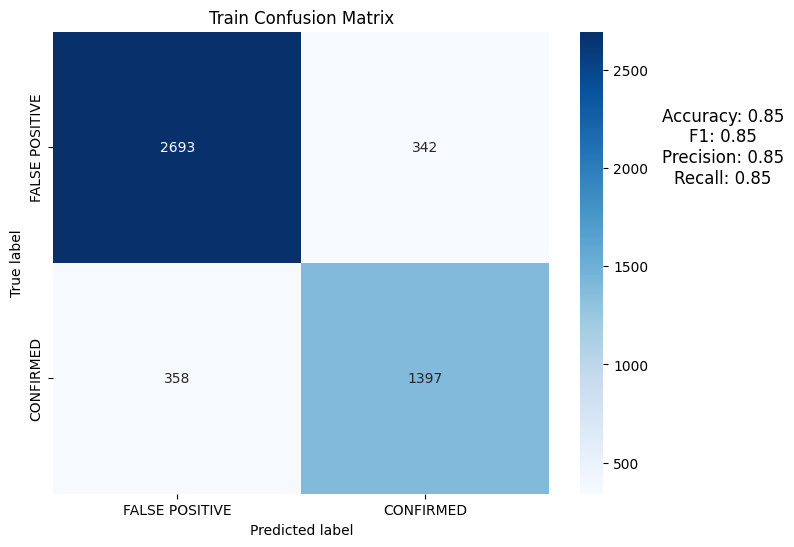

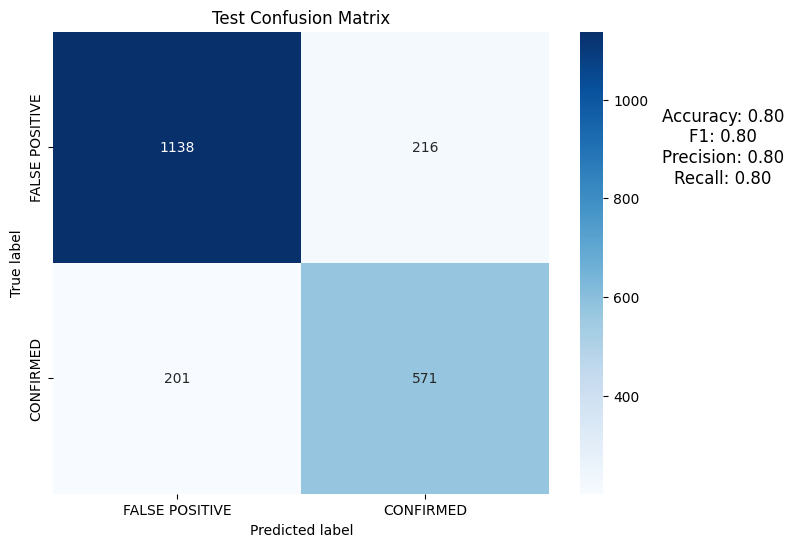

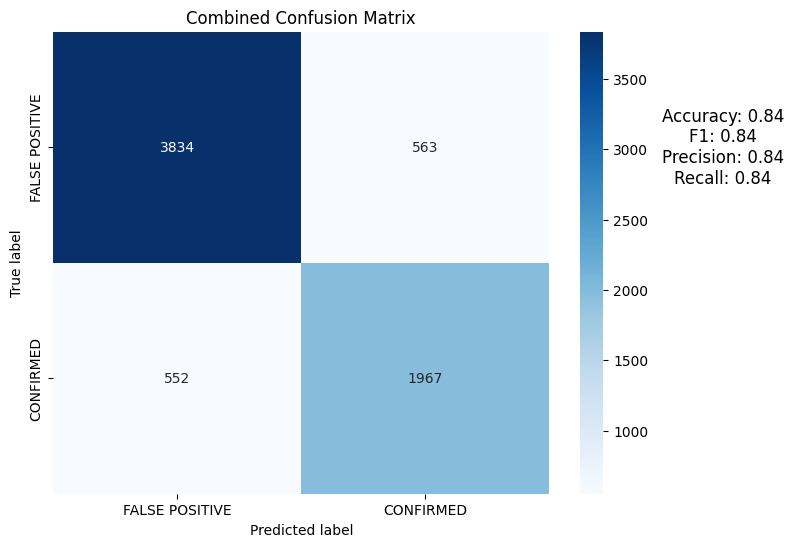

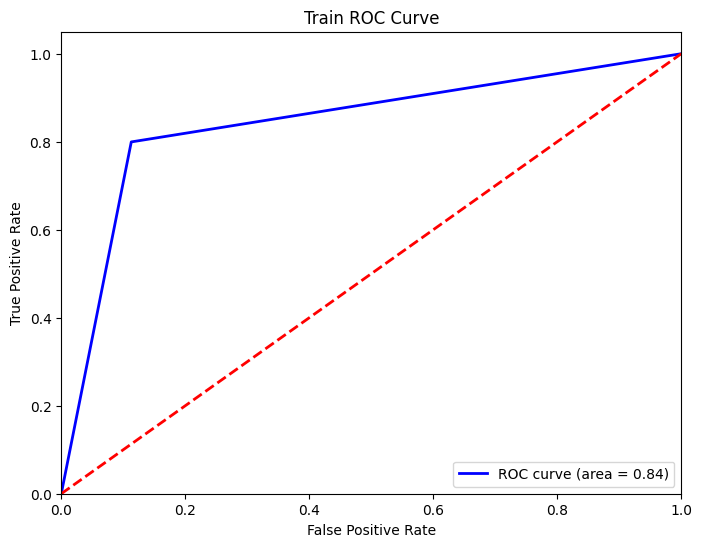

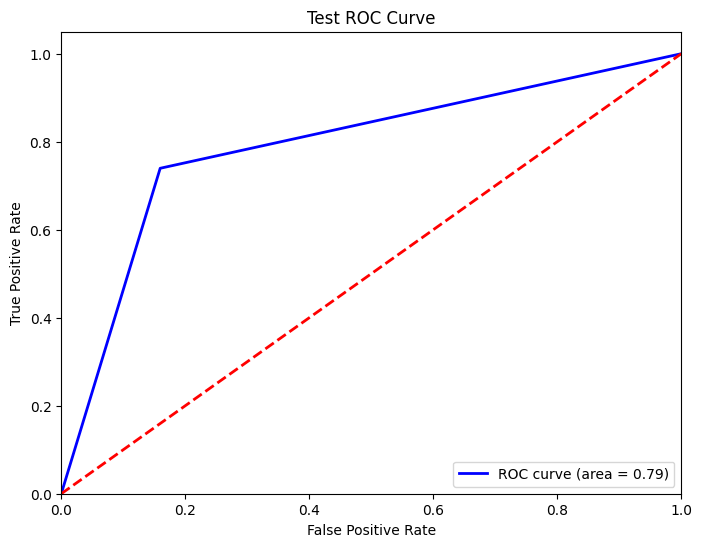

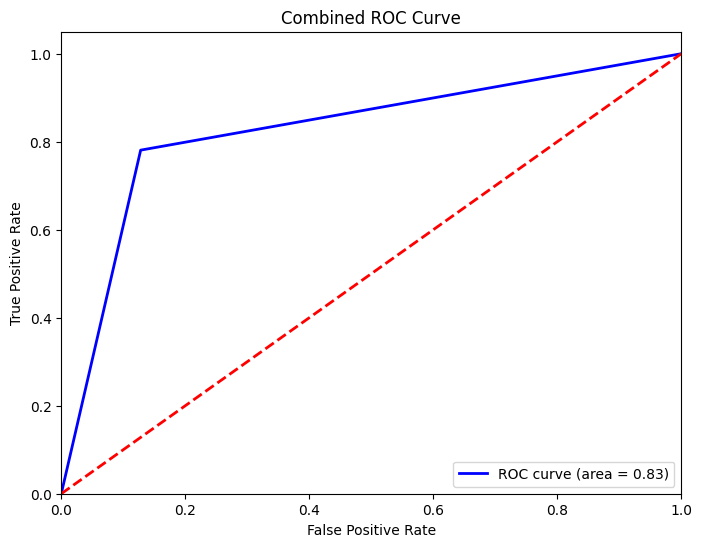

In [ ]:

predicted, labels = predict(model, train_loader)
plot_confusion_matrix(labels, predicted, classes, title='Train Confusion Matrix')

predicted, labels = predict(model, test_loader)
plot_confusion_matrix(labels, predicted, classes, title='Test Confusion Matrix')

# combine the train and test datasets
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False)
predicted, labels = predict(model, combined_loader)
plot_confusion_matrix(labels, predicted, classes, title='Combined Confusion Matrix')


# plot the ROC curve
def plot_roc_curve(y_true, y_pred, title='ROC Curve'):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
predicted, labels = predict(model, train_loader)
plot_roc_curve(labels, predicted, title='Train ROC Curve')

predicted, labels = predict(model, test_loader)
plot_roc_curve(labels, predicted, title='Test ROC Curve')

predicted, labels = predict(model, combined_loader)
plot_roc_curve(labels, predicted, title='Combined ROC Curve')



## Probar el modelo con los datos de CANDIDATOS

In [45]:
global_odd = []
global_even = []
local_odd = []
local_even = []

for lc in tqdm(candidates, desc='Processing light curves'):
    global_odd.append(lc.pliegue_impar_global._light_curve.flux.value)
    global_even.append(lc.pliegue_par_global._light_curve.flux.value)
    local_odd.append(lc.pliegue_impar_local._light_curve.flux.value)
    local_even.append(lc.pliegue_par_local._light_curve.flux.value)

items = []
for i in tqdm(range(len(global_odd)), desc='Creating items'):
    item = {
        'global': (global_odd[i], global_even[i]),
        'local': (local_odd[i], local_even[i]),
        'label': -1 # No label for candidates
    }
    items.append(item)

candidates_global = torch.tensor([[item['global'][0], item['global'][1]] for item in items])
candidates_local = torch.tensor([[item['local'][0], item['local'][1]] for item in items])
candidates_labels = torch.tensor([item['label'] for item in items])
candidates_dataset = torch.utils.data.TensorDataset(candidates_global, candidates_local, candidates_labels)

print("Tamaño del conjunto de candidatos:", len(candidates_dataset))

candidates_loader = DataLoader(candidates_dataset, batch_size=batch_size, shuffle=False)

Creating items: 100%|██████████| 2046/2046 [00:00<00:00, 2047612.98it/s]


Tamaño del conjunto de candidatos: 2046


In [46]:
predicted_candidates, _ = predict(model, candidates_loader)


In [47]:
# contar los positivos y negativos
n_positive = sum(predicted_candidates)
n_negative = len(predicted_candidates) - n_positive
print("Exoplanetas confirmados:", n_positive)
print("Falso positivo:", n_negative)

Exoplanetas confirmados: 725.0
Falso positivo: 1065.0
